In [1]:
import html
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

import nltk
from scipy.special import softmax
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

nltk.download('stopwords')
from string import punctuation

import pymorphy2
from nltk.corpus import stopwords

russian_stopwords = stopwords.words("russian")
blacklist = set(punctuation)
blacklist.update(['«', '»'])

morph = pymorphy2.MorphAnalyzer()

import seaborn as sns
from sklearn.metrics import confusion_matrix

FILE_NAME = '20230410_063834.csv'
CUR_DIR = Path('__file__').resolve().parent
DATA_DIR = CUR_DIR/ 'data/'
FILE_PATH = DATA_DIR / FILE_NAME

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kate\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
doctors = dict()
doctors['Акушер-гинеколог'] = ['Акушер-гинеколог', 'врач – акушер-гинеколог', 'врач-гинеколог']
doctors['Аллерголог-иммунолог'] = ['Аллерголог-иммунолог', 'врач – аллерголог-иммунолог']
doctors['Анестезиолог-реаниматолог'] = ['Анестезиолог-реаниматолог', 'врач – анестезиолог-реаниматолог', 'врач-реаниматолог']
doctors['Гастроэнтеролог'] = ['врач-гастроэнтеролог', 'Гастроэнтеролог']
doctors['Дерматовенеролог'] = ['Дерматовенеролог', 'врач-дерматовенеролог']
doctors['Инфекционист'] = ['Инфекционист', 'врач-инфекционист']
doctors['Кардиолог'] = ['Кардиолог', 'врач-кардиолог', 'Детский кардиолог', 'врач – детский кардиолог']
doctors['Невролог'] = ['Невролог', 'врач-невролог']
doctors['Неонатолог'] = ['Неонатолог', 'врач-неонатолог']
doctors['Нефролог'] = ['Нефролог', 'врач-нефролог']
doctors['Онколог'] = ['Онколог', 'врач-онколог', 'Детский онколог','врач – детский онколог']
doctors['Оториноларинголог'] = ['Оториноларинголог', 'врач-оториноларинголог', 'Сурдолог-оториноларинголог']
doctors['Офтальмолог'] = ['Офтальмолог', 'врач-офтальмолог', 'Офтальмолог-протезист','врач – офтальмолог-протезист']
doctors['Педиатр'] = ['Педиатр', 'врач-педиатр', 'врач-педиатр участковый']
doctors['Психиатр'] = ['Психиатр', 'Психиатр-нарколог', 'врач-психиатр', 'врач-психиатр детский',
                        'Детский психиатр', 'Психотерапевт', 'врач-психотерапевт', 'врач – психиатр-нарколог', 'врач-нарколог']
doctors['Пульмонолог'] = ['Пульмонолог', 'врач-пульмонолог']
doctors['Ревматолог'] = ['Ревматолог', 'врач-ревматолог']
doctors['Стоматолог'] = ['Стоматолог', 'Стоматолог-терапевт', 'Стоматолог-ортопед', 'Стоматолог-хирург',
                        'Детский стоматолог', 'врач-стоматолог', 'врач – стоматолог-хирург', 'Ортодонт', 
                        'врач – стоматолог-ортопед', 'врач-стоматолог детский', 'врач – стоматолог-терапевт']
doctors['Терапевт'] = ['Терапевт', 'врач-терапевт', 'врач-терапевт участковый']
doctors['Травматолог'] = ['Травматолог', 'Травматолог-ортопед', 'врач – травматолог-ортопед']
doctors['Уролог'] = ['Уролог', 'врач-уролог', 'врач – детский уролог-андролог', 'Детский уролог-андролог']
doctors['Рентгенолог'] = ['Врач ультразвуковой диагностики', 'врач по рентгенэндоваскулярным методам диагностики и лечения', 'врач-рентгенолог',
                         'Рентгенолог', 'Врач по рентгенэндоваскулярным методам диагностики и лечения', 'врач ультразвуковой диагностики',
                          'Радиолог', 'Врач по рентгенэндоваскулярным диагностике и лечению', 'врач по рентгенэндоваскулярным диагностике и лечению']
doctors['Фтизиатр'] = ['Фтизиатр', 'врач-фтизиатр', 'врач-фтизиатр участковый']
doctors['Хирург'] = ['врач – сердечно-сосудистый хирург', 'Детский хирург', 'Хирург', 'Сердечно-сосудистый хирург', 'врач-хирург',
                         'врач – детский хирург', 'врач – торакальный хирург', 'врач-нейрохирург', 'врач-кардиохирург', 'Нейрохирург',
                          'Челюстно-лицевой хирург', 'Торакальный хирург', 'врач – челюстно-лицевой хирург', 'Пластический хирург', 'врач – пластический хирург']
doctors['Эндокринолог'] = ['Эндокринолог', 'врач-эндокринолог', 'Детский эндокринолог', 'врач – детский эндокринолог']

In [101]:
df = pd.read_csv(FILE_PATH, delimiter=';')[['ID группы', 'Mod документа','ID документа','Название документа','Врачи']]
df = df[~df['Врачи'].isna()]
df = df[df['Mod документа'].isin([16,118,30,39,26,184])]
df = df.drop_duplicates()
therapist_docs = list(df[df['Врачи'] == 'Терапевт']['Название документа'])

df = df.assign(Врач=df['Врачи'].str.split('; ')).explode('Врач').reset_index(drop=True)
df = df.drop(['Врачи'], axis=1)
df = df.groupby('ID группы').filter(lambda x: len(x) < 4)

for i, value in df['Врач'].items():
    for key, val_list in doctors.items():
        if value in val_list:
            df.at[i, 'Врач'] = key
            break
        
df["Врач"] = df["Врач"].apply(lambda x: x if x in doctors.keys() else None)
df = df.dropna(subset=['Врач'])
#для терапевтов оставляем только те документы, для которых нет отнесения к другим специальностям
df = df.loc[~((df['Врач'] == 'Терапевт') & (~df['Название документа'].isin(therapist_docs)))]
print(len(df))
print(len(df['Врач'].unique()))
df.head()

11381
25


ID группы  Mod документа  ID документа  \
0    86619059             30          1557   
3    92117498             16        118926   
4    84716339             16        111148   
5    84716339             16        111148   
28   86508501             30          1554   

                                   Название документа              Врач  
0   Воспалительные болезни шейки матки, влагалища ...  Акушер-гинеколог  
3   Стандарт первичной медико-санитарной помощи вз...      Эндокринолог  
4   Стандарт медицинской помощи взрослым при артер...         Кардиолог  
5   Стандарт медицинской помощи взрослым при артер...            Хирург  
28               Холецистит: клиническая рекомендация   Гастроэнтеролог

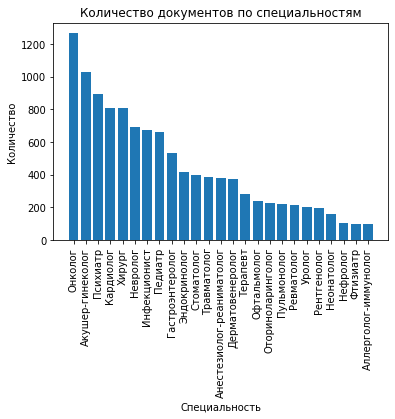

In [102]:
doctor_counts = df["Врач"].value_counts()
plt.bar(doctor_counts.index, doctor_counts.values)

plt.xticks(rotation=90)
plt.title("Количество документов по специальностям")
plt.xlabel("Специальность")
plt.ylabel("Количество")

plt.show()

In [103]:
def concatenate_documents(group):
    shuffled_group = group.sample(frac=1, random_state=42) 
    concatenated_documents = []
    for i in range(0, len(shuffled_group), 5):
        concatenated_documents.append('. '.join(shuffled_group.iloc[i:i+5]['Название документа']))
    return pd.Series(concatenated_documents, index=[f'Object {i+1}' for i in range(len(concatenated_documents))])

new_df = df.groupby('Врач').apply(concatenate_documents).reset_index().drop('level_1', axis=1).rename(columns={0: 'Текст'})

new_df.head()

Врач                                              Текст
0  Акушер-гинеколог  Американские ученые разработали новый молекуля...
1  Акушер-гинеколог  Акушер-гинеколог. Дневник курации при трофобла...
2  Акушер-гинеколог  Критерии оценки качества медицинской помощи пр...
3  Акушер-гинеколог  Вышел новый американский гайдлайн по маститам....
4  Акушер-гинеколог  Критерии оценки качества медицинской помощи пр...

In [104]:
def lemmatize(text: str) -> str:
    """returns a list, consisting of the lemmas from the input string"""
    text = html.unescape(text)
    text = re.sub(r'[\s\xa0\u202F\uFEFF]+', ' ', text)

    words = text.split() # разбиваем текст на слова
    res = [] 
    for word in words:
        word = ''.join(c for c in word if (c not in blacklist and c.isdigit()==False)) #удаляем знаки препинания и цифры
        if len(word)>=3: #для всех слов, состоящих из трех и более букв, во множество ответов записываем нормальную форму слова
            word = morph.parse(word)[0].normal_form
            res.append(word)

    return (' ').join(res)

In [105]:
new_df['Текст'] = new_df['Текст'].str.replace('-', ' ')
new_df['Текст'] = new_df['Текст'].str.replace('/', ' ')

In [106]:
text = new_df.sample()['Текст'].values[0]
print(text)
print()
print(lemmatize(text))

Информация для пациентов с глаукомой первичной открытоугольной. Стандарт специализированной медицинской помощи при экзофтальме, связанном с нарушением функции щитовидной железы. Протокол ведения взрослых с диабетической ретинопатией и диабетическим макулярным отеком. Минздрав одобрил один из самых дорогих препаратов для лечения редкого офтальмологического заболевания. Алгоритмы ведения пациента с глаукомой первичной открытоугольной

информация для пациент глаукома первичный открытоугольный стандарт специализировать медицинский помощь при экзофтальм связанный нарушение функция щитовидный железа протокол ведение взрослый диабетический ретинопатия диабетический макулярный отёк минздрав одобрить один самый дорогой препарат для лечение редкий офтальмологический заболевание алгоритм ведение пациент глаукома первичный открытоугольный


In [107]:
new_df['Текст'] = new_df['Текст'].progress_apply(lemmatize)

100%|██████████| 2285/2285 [00:25<00:00, 87.90it/s] 


In [132]:
new_df.to_csv('data_lemmatized.csv', index=False)

In [108]:
train_data, test_data, train_labels, test_labels = train_test_split(new_df['Текст'], new_df['Врач'], test_size=0.2, random_state=42, shuffle=True, stratify=new_df['Врач'])
print("Training data shape:", train_data.shape)
print("Training labels shape:", train_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)

Training data shape: (1828,)
Training labels shape: (1828,)
Test data shape: (457,)
Test labels shape: (457,)


In [109]:
X = list(train_data) #матрица признаков
y = list(train_labels) # целевой вектор

In [110]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

text_clf = Pipeline([('tfidf', TfidfVectorizer(max_features= 5000, ngram_range = (1,2), stop_words = russian_stopwords, analyzer = 'word')), 
                    ('clf', LinearSVC(C=1, class_weight = 'balanced', random_state = 1))])

In [111]:
f1_scores = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]
    
    text_clf.fit(X_train, y_train)
    y_pred = text_clf.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f1)

    f1_scores.append(f1)

mean_f1_score = sum(f1_scores) / len(f1_scores)
print("Mean F1 score:", mean_f1_score)

0.9171206729741986
0.938989749929931
0.9282176519437506
0.9076582178264775
0.913113974187036
Mean F1 score: 0.9210200533722788


In [112]:
text_clf.fit(train_data, train_labels)
predictions = text_clf.predict(test_data)

test_df = pd.DataFrame({'Текст': test_data, 'Врач': test_labels})
test_df['Prediction'] = predictions

f1_score(list(test_labels), predictions, average='weighted')

0.9421901492956366

In [114]:
cm = confusion_matrix(list(test_labels), predictions)
df_cm = pd.DataFrame(cm, columns=np.unique(list(test_labels)), index = np.unique(predictions))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

In [ ]:
plt.figure(figsize = (15,10))
sns.heatmap(df_cm, cmap='Blues', annot=True, square=True)

: 

# Тестовые данные

In [122]:
user = pd.read_csv('data/users/20230414_192602.csv', delimiter=';')
user = user[~user['Переход на документ'].isna()][['Переход на документ']].reset_index(drop=True).loc[0:20]
user = user.drop_duplicates()
user['Переход на документ'] = user['Переход на документ'].str.replace('-', ' ')
user['Переход на документ'] = user['Переход на документ'].str.replace('/', ' ')
user['Переход на документ'] = user['Переход на документ'].progress_apply(lemmatize)
text = ' '.join(user['Переход на документ'].values)
print(text)
decision_scores = text_clf.decision_function([text])[0]
top5_indices = np.argsort(decision_scores)[::-1][:5]
top5_probabilities = softmax(decision_scores[top5_indices])
classes = text_clf.classes_
for i in range(len(top5_indices)):
    print("{}: {:.3f}".format(classes[top5_indices[i]], top5_probabilities[i]))

100%|██████████| 5/5 [00:00<00:00, 624.97it/s]

перечень клинический рекомендация обязательный клинический практика январь год протокол ведение взрослый пациент мигрень шум ухо субъективный стандарт специализировать медицинский помощь при поражение лицевой нерв клинический рекомендация мононевропатия
Невролог: 0.411
Оториноларинголог: 0.158
Стоматолог: 0.151
Хирург: 0.142
Дерматовенеролог: 0.138


# Fasttext

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MLops_2023/data_lemmatized2.csv')[['Врач', 'Текст']]
print(len(df))
df.head()

In [ ]:
#add __label__ in front of the labels for fastText to read
df_labeled = df.copy()
df_labeled['Врач'] = '__label__' + df_labeled['Врач'].astype(str)
df_labeled.head()

In [ ]:
category_prod = df_labeled['Врач'] + " " + df_labeled['Текст']
print(category_prod)

In [ ]:
#split into train and test
train, test = train_test_split(category_prod, test_size=0.3, train_size=0.7, random_state=42)

In [ ]:
#write test and train into files
f_train = open("train.txt", "a")
for i in range(len(np.array(train))):
    f_train.write(np.array(train)[i] + "\n")
f_train.close()

f_test = open("test.txt", "a")
for i in range(len(np.array(test))):
    f_test.write(np.array(test)[i] + "\n")
f_test.close()

In [ ]:
model = fasttext.train_supervised('train.txt', autotuneValidationFile='test.txt')

In [ ]:
model.test("test.txt")

In [ ]:
model.save_model('optimized.model')

In [ ]:
text = 'комплект соп вкк лечебный диагностический процедура краткий гид клинический рекомендация сенсоневральный тугоухость взрослый протокол ведение взрослый пациент хронический сенсоневральный тугоухость сенсоневральный тугоухость взрослый клинический рекомендация клинический случай делириозной расстройство фон деменции чувство долг жизнь врач совет упражнение психолог как попасть манипулятивный ловушка как правильно оформлять информированный добровольный согласие как правильно оформлять информированный добровольный согласие посттравматический стрессовый расстройство клинический рекомендация менингококковый инфекция ребёнок клинический рекомендация чек лист киль чек лист киль как проводить киль психиатр повторный осмотр при шизофрения взрослый стационар'

# Пример классификации одного заголовка
model.predict(text, k=5)